In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="last"


In [2]:
import pandas as pd
pd.set_option("display.precision", 5)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.inspection import DecisionBoundaryDisplay

from tqdm.notebook import trange, tqdm

data_raw=pd.read_csv("data_ml_v2-14.csv")
data_x = data_raw[data_raw.columns[0:-1]]
data_y = data_raw[data_raw.columns[-1]]
random_state=42



In [3]:
data_describe = data_x.describe()
data_describe

,x1,x2
count,650.00000,650.00000
mean,1.98253,2.02305
std,2.07787,2.18133
min,-3.70780,-3.65820
25%,0.61740,0.34443
50%,1.87015,1.94105
75%,3.47765,3.67800
max,8.82140,9.21490


In [6]:
def find_bindwidth(x: pd.Series):
    return 0.9 * min(x.var()**0.5, (x.quantile(0.75) - x.quantile(0.25))/1.34) * len(x)**(-0.2)

class MyDenceEstim(BaseEstimator):
    def __init__(self, kernel, bandwidth: list) -> None:
        self.kernel = {"tophat": lambda x: 0.5*(abs(x)<1), 
                        "gaussian": lambda x: np.exp(-x**2/2)/(2*np.pi)**0.5, 
                        "epanechnikov": lambda x: 0.75*(1-x**2)*(abs(x)<1),
                         "linear": lambda x: (1-abs(x))*(abs(x)<1)}[kernel]
        self.bandwidth = bandwidth
    def fit(self, X):
        if type(X) is not np.ndarray:
            X=np.array(X)
        self.data = X.reshape(X.shape[0], 1, X.shape[1])
        return self
    def score_samples(self, X):
        if type(X) is not np.ndarray:
            X=np.array(X)
        dense = self.kernel((self.data-X)/self.bandwidth)
        dense = (dense[:,:,0] * dense[:,:,1]).sum(axis = 0)
        dense/=(self.data.shape[0]*self.bandwidth[0]*self.bandwidth[1])
        return dense

class MyClassifier(BaseEstimator):
    def __init__(self) -> None:
        pass
    def fit(self, X: pd.DataFrame, y: pd.DataFrame, kernel: str, bandwidth: list):
        self.estim_pos = MyDenceEstim(kernel=kernel, bandwidth=bandwidth).fit(X.loc[y==1])
        self.estim_neg = MyDenceEstim(kernel=kernel, bandwidth=bandwidth).fit(X.loc[y==-1])
        self.prior_pos = len(y.loc[y==1])/len(y)
        self.prior_neg = len(y.loc[y==-1])/len(y)
        self.__sklearn_is_fitted__ = lambda : True
        return self
    def predict(self, X):
        return np.argmax([self.estim_neg.score_samples(X)*self.prior_neg,
                          self.estim_pos.score_samples(X)*self.prior_pos], axis=0)*2-1
    def predict_proba(self, X):
        score_pos = self.estim_pos.score_samples(X)*self.prior_pos
        score_neg = self.estim_neg.score_samples(X)*self.prior_neg
        return score_pos/(score_pos+score_neg+(score_pos==0)/1e10)
    def score_sample_pos(self, X):
        return self.estim_pos.score_samples(X)
    def score_sample_neg(self, X):
        return self.estim_neg.score_samples(X)


# Пункт 1

  0%|          | 0/4 [00:00<?, ?it/s]

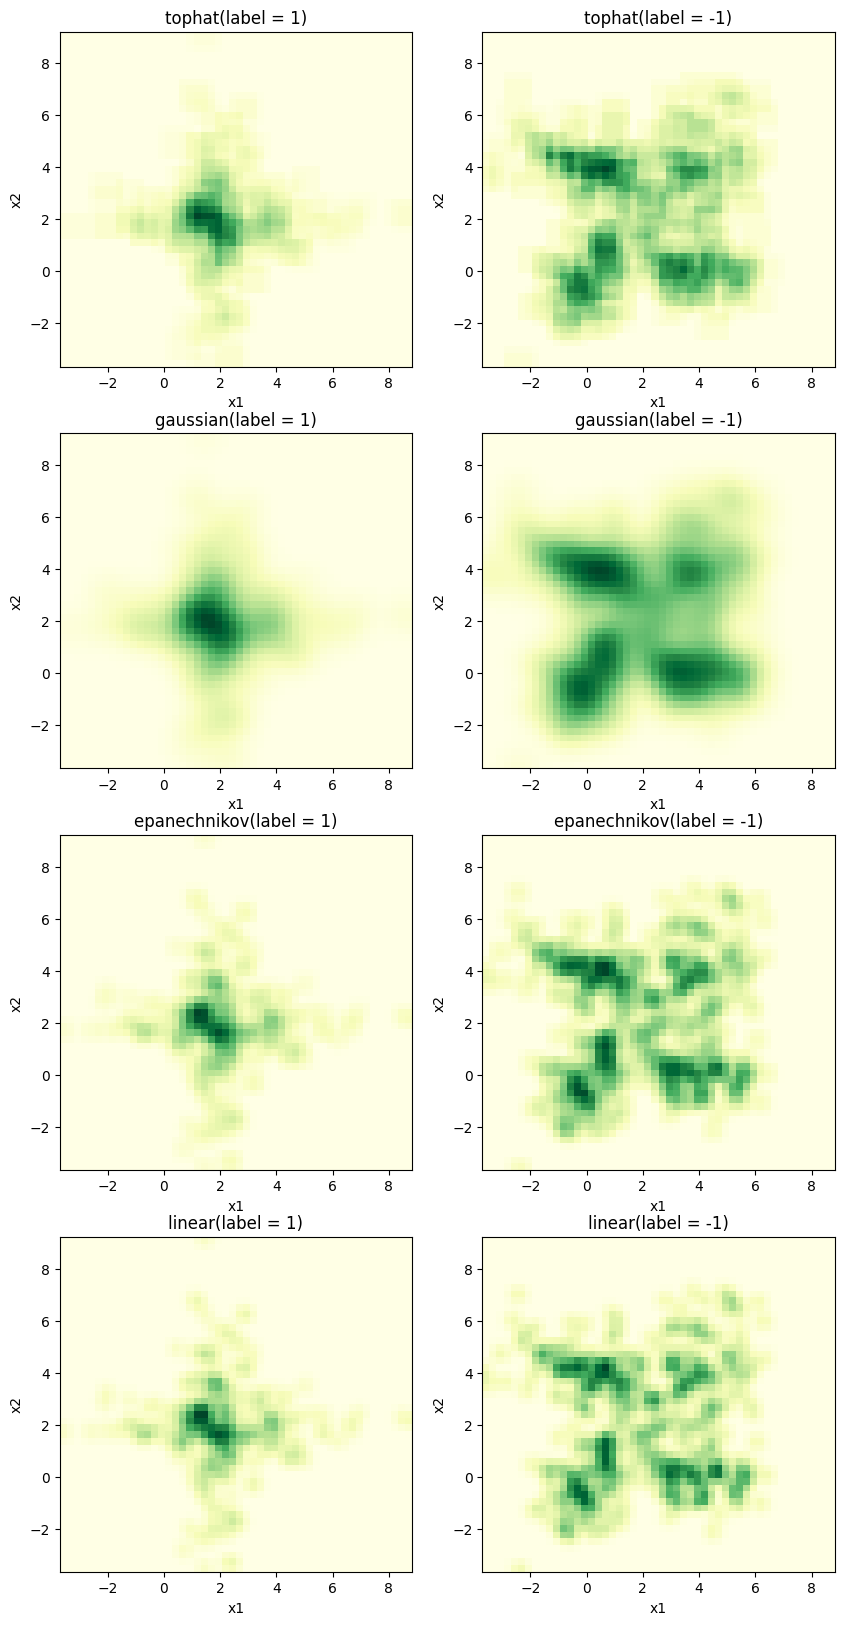

In [7]:
InteractiveShell.ast_node_interactivity="none"
kernels = ["tophat", "gaussian", "epanechnikov", "linear"]
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(10, 20)
X = pd.DataFrame([np.broadcast_to(np.linspace(data_describe["x1"]["min"], data_describe["x1"]["max"], 100), (100,100)).T.flatten(), 
                  np.broadcast_to(np.linspace(data_describe["x2"]["min"], data_describe["x2"]["max"], 100), (100,100)).flatten()], index=["x1", "x2"]).T
my_classifier = MyClassifier()
for i in trange(4):
    my_classifier.fit(data_x, data_y, kernels[i], [find_bindwidth(data_x["x1"]), find_bindwidth(data_x["x2"])])
    ax[i][0].hist2d(X["x1"], X["x2"], 50, weights=my_classifier.score_sample_pos(X), cmap="YlGn")
    ax[i][0].set_xlabel("x1")
    ax[i][0].set_ylabel("x2")
    ax[i][0].set_title(f"{kernels[i]}(label = 1)")
    ax[i][1].hist2d(X["x1"], X["x2"], 50, weights=my_classifier.score_sample_neg(X), cmap="YlGn")
    ax[i][1].set_xlabel("x1")
    ax[i][1].set_ylabel("x2")
    ax[i][1].set_title(f"{kernels[i]}(label = -1)")

InteractiveShell.ast_node_interactivity="last"



# Пункт 2

In [8]:
cv = KFold(shuffle=True)
acc = np.array([[0.]*5 for i in range(4)])
for j in range(len(kernels)):
     for i, (train_index, test_index) in enumerate(cv.split(data_x, data_y)):
          my_classifier.fit(data_x.iloc[train_index], data_y.iloc[train_index], kernels[j], 
                            [find_bindwidth(data_x["x1"][train_index]), find_bindwidth(data_x["x2"][train_index])])
          pred = my_classifier.predict(data_x.iloc[test_index])
          acc[j][i] = accuracy_score(data_y.iloc[test_index], pred)

acc = pd.DataFrame(acc.T, columns=kernels)
(acc.describe().loc[["std", "mean"]])


,tophat,gaussian,epanechnikov,linear
std,0.03335,0.02631,0.02216,0.03218
mean,0.74154,0.76000,0.74923,0.75385


# Пункт 3

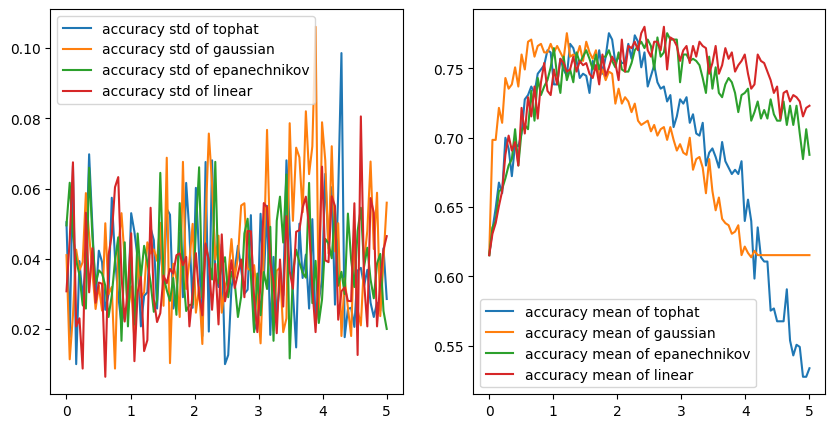

In [9]:
# InteractiveShell.ast_node_interactivity="none"
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

cv = KFold(5, shuffle=True)

n_points = 100
acc_gr = np.zeros((n_points, 2, 4))
lm = np.linspace(1e-5, 5, n_points)
for k in range(n_points):
    acc_temp = np.array([[0.]*5 for i in range(4)])
    for j in range(len(kernels)):
        for i, (train_index, test_index) in enumerate(cv.split(data_x, data_y)):
            my_classifier.fit(data_x.iloc[train_index], data_y.iloc[train_index], kernels[j], 
                                [lm[k]*find_bindwidth(data_x["x1"][train_index]), lm[k]*find_bindwidth(data_x["x2"][train_index])])
            pred = my_classifier.predict(data_x.iloc[test_index])
            acc_temp[j][i] = accuracy_score(data_y.iloc[test_index], pred)
    acc_temp = np.array(pd.DataFrame(acc_temp.T, columns=kernels).describe().loc[["std", "mean"]])
    acc_gr[k] = acc_temp

for i in range(len(kernels)):
    ax[0].plot(lm, acc_gr[:, 0, i], label = f"accuracy std of {kernels[i]}")
    ax[0].legend()
    ax[1].plot(lm, acc_gr[:, 1, i], label = f"accuracy mean of {kernels[i]}")
    ax[1].legend()

InteractiveShell.ast_node_interactivity="last"
    

In [10]:

optim_vec = pd.DataFrame([[lm[np.argmax(acc_gr[:,1,i])]*find_bindwidth(data_x["x1"]), 
                           lm[np.argmax(acc_gr[:,1,i])]*find_bindwidth(data_x["x2"]),
                          np.max(acc_gr[:,1,i])] for i in range(len(kernels))], 
                          columns=["bandwidth of x1", "bandwidth of x2", "accuracy"], index=kernels)
optim_vec


,bandwidth of x1,bandwidth of x2,accuracy
tophat,0.95679,1.00443,0.77538
gaussian,0.62062,0.65152,0.77538
epanechnikov,1.42225,1.49307,0.77538
linear,1.24124,1.30304,0.78000


# Пункт 4

In [11]:
from sklearn.naive_bayes import GaussianNB

In [12]:
bayes_cl = GaussianNB()
cv = KFold(shuffle=True)
acc = np.array([0.]*5)
for i, (train_index, test_index) in enumerate(cv.split(data_x, data_y)):
    bayes_cl.fit(data_x.iloc[train_index], data_y.iloc[train_index])
    pred = bayes_cl.predict(data_x.iloc[test_index])
    acc[i] = accuracy_score(data_y.iloc[test_index], pred)

acc = pd.DataFrame(acc.T, columns=["Naive Bayes"])
(acc.describe().loc[["std", "mean"]])




,Naive Bayes
std,0.04679
mean,0.68462


# Пункт 5

In [25]:
# best_bandwidth = [lm[np.argmax(acc_gr[:,1,:])//4]*find_bindwidth(data_x["x1"]), 
#                   lm[np.argmax(acc_gr[:,1,:])//4]*find_bindwidth(data_x["x2"])]
best_bandwidth = [lm[-1]*find_bindwidth(data_x["x1"]), 
                  lm[-1]*find_bindwidth(data_x["x2"])]
# best_ker = kernels[np.argmax(acc_gr[:,1,:])-(np.argmax(acc_gr[:,1,:])//4)*4]
best_ker = kernels[3]

print(f"best bandwidth is {best_bandwidth}\nbest kernel is {best_ker}\n(accuracy = {np.max(acc_gr[:,1,:])})")

best bandwidth is [2.5600547294647127, 2.687517111630485]
best kernel is linear
(accuracy = 0.7799999999999999)


Text(0.5, 1.0, 'Bayes classifier')

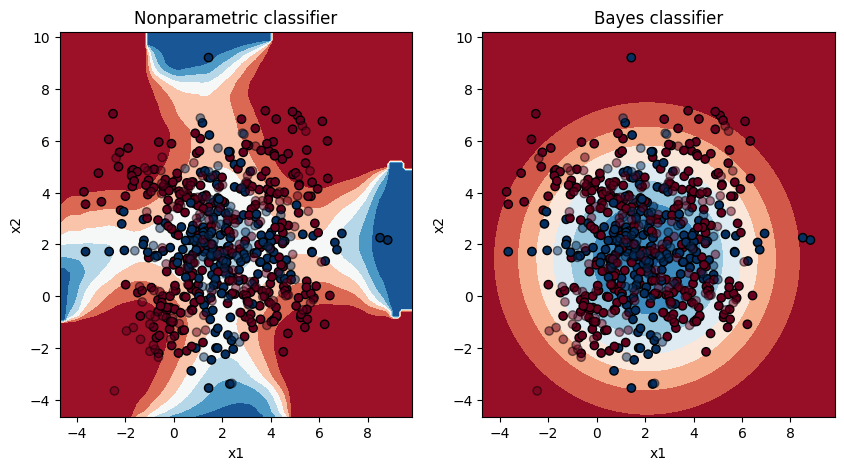

In [26]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10, 5)

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.3, random_state=random_state)

my_classifier = MyClassifier()
my_classifier.fit(X_train, y_train, best_ker, best_bandwidth)
bayes_cl.fit(X_train, y_train)
DecisionBoundaryDisplay.from_estimator(my_classifier, data_x, cmap="RdBu", ax=ax[0])
ax[0].scatter(X_train["x1"], X_train["x2"], c=y_train, cmap="RdBu", edgecolors="k")
ax[0].set_title("Nonparametric classifier")
ax[0].scatter(X_test["x1"], X_test["x2"], c=y_test, cmap="RdBu", edgecolors="k", alpha=0.5)
DecisionBoundaryDisplay.from_estimator(bayes_cl, data_x, cmap="RdBu", ax=ax[1])
ax[1].scatter(X_train["x1"], X_train["x2"], c=y_train, cmap="RdBu", edgecolors="k")
ax[1].scatter(X_test["x1"], X_test["x2"], c=y_test, cmap="RdBu", edgecolors="k", alpha=0.5)
ax[1].set_title("Bayes classifier")
